# Modeling for Housing Price Prediction
---

After model benchmarks, we found the best model that give most closer picked by RMSC value among `OLS`, `Regularization`, `Ridge`, `Lasso`, `ElasticNet`, `Robust Regression`, `TheilSen`, `RANSAC` , `Huber` is OLS from [**model_benchmarks**](./Code/3.Model_Benchmarks.ipynb) notebook

In [466]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn import metrics
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler


In [467]:
modeling_data = pd.read_csv('../Datasets/bangkok_preprocess.csv')

In [468]:
features = sorted(list(set(modeling_data.columns)-{'price'}))

In [469]:
# Setting Our Features and Targets
X = modeling_data[features]
y = modeling_data['price']

In [470]:
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size= 0.75 , random_state=42)

---

### Model Tuning 

In [473]:
lr = LinearRegression()
lr.fit(X_train,y_train)
train_score = lr.score(X_train,y_train)
test_score = lr.score(X_test,y_test)
modeling_data['predict_price'] = lr.predict(X)
y_preds = modeling_data['predict_price']
modeling_data['residuals'] = y - y_preds
residuals = modeling_data['residuals']
cvs = cross_val_score(lr, X, y, cv = 6)

In [474]:
# Function for Calculating Adjusted R-Squared
def r2_adj(y, y_preds, p):
    n = len(y)
    r2 = metrics.r2_score(y, y_preds)
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

In [475]:
# Function for Calculating Metrics in the Model
def king_of_metrics(y, y_preds, p): 

    mse = metrics.mean_squared_error(y, y_preds)
    rmse = metrics.root_mean_squared_error(y, y_preds)
    mae = metrics.mean_absolute_error(y, y_preds)
    r2 = metrics.r2_score(y, y_preds)
    r2a = r2_adj(y, y_preds, p)


    print(f"Regression Metric number the features is: ")
    print(f"bedrooms, baths, floor_area, province, district, property_type, nearby_stations, nearby_supermarkets, facilities, num_facilities\n")
    print(f"The mean squared error is {mse:,.2f}")
    print(f"The root mean squared error is {rmse:,.2f}")
    print(f"The mean absolute error is {mae:,.2f}")
    print(f"The R^2 is {r2:,.2f}")
    print(f"Adjusted R^2 = {r2a:,.2f}\n")
    print(f"train score = {train_score:,.2f}")
    print(f"test score = {test_score:,.2f}\n")
    print(f"Cross Validation Score cv = 6 : {cvs}")
king_of_metrics(y,y_preds, 30)

Regression Metric number the features is: 
bedrooms, baths, floor_area, province, district, property_type, nearby_stations, nearby_supermarkets, facilities, num_facilities

The mean squared error is 1,148,328,651,103.89
The root mean squared error is 1,071,600.98
The mean absolute error is 787,031.07
The R^2 is 0.76
Adjusted R^2 = 0.76

train score = 0.77
test score = 0.73

Cross Validation Score cv = 6 : [0.75458932 0.71583425 0.75980077 0.73203428 0.7292449  0.76168506]


---

# Test Data

In [478]:
import warnings
from pandas.errors import PerformanceWarning

# Ignore PerformanceWarning
warnings.filterwarnings("ignore", category=PerformanceWarning)

In [479]:
bangkok_test = pd.read_csv('../Datasets/test_preprocess.csv')

In [480]:
# Get all columns to features except price
test_features = list(set(bangkok_test.columns)-{'price'})

In [481]:
# # Check the columns to match the features in the training data and add a 'False' value in a new column
features_add = list(set(features) - set(test_features))
test_features = sorted(test_features + features_add)
bangkok_test[features_add] = False

In [482]:
# Write a Function to Input Data into an Already Trained Model
def predict_test_model(features,data):
    X = data[features]
    X = X.copy()
    data['price'] = lr.predict(X)

    return data[['id','price']]

submit_on_kaggle = predict_test_model(features,bangkok_test)

In [483]:
submit_on_kaggle.to_csv('../Datasets/test_predict_price.csv', index = False)

---

# Presentation Material Support

In [486]:
coef = pd.DataFrame({'Feature': X.columns, 'Coefficient': lr.coef_})

---

In [488]:
station_coef = coef[coef['Feature'].str.contains('MRT|BTS')].sort_values(by='Coefficient', ascending=True)
station_coef['Coefficient'] = station_coef['Coefficient'] *-100
station_coef['Feature'] = station_coef['Feature'].str.replace('stat_','')

In [489]:
get_district = pd.read_csv('../Datasets/bangkok_cleaned.csv')

### 1. Top 5 Stations with the Strongest Influence on Housing Prices

In [491]:
station_samples = get_district.groupby('station_name').size().reset_index(name='count')
station_coef_sample = pd.merge(station_coef,station_samples, left_on= 'Feature', right_on= 'station_name')

In [492]:
station_coef_sample['count'].skew(), station_coef_sample['count'].median(),station_coef_sample['count'].mean()

(1.8106857695393013, 42.0, 60.132075471698116)

In [493]:
station_coef_sample = station_coef_sample[station_coef_sample['count'] >= 42].head(5)
station_coef_sample['line'] = station_coef_sample['station_name'].apply(lambda x: x.split(' ')[-1] if isinstance(x, str) else x)
station_coef_sample['station_name'] = station_coef_sample['station_name'].apply(lambda x:  ' '.join(x.split(' ')[:-1]) if isinstance(x, str) else x)
station_coef_sample.drop(columns = 'Feature')

,Coefficient,station_name,count,line
1,353424.557278,Phetchaburi,46,MRT
4,312668.215063,Sam Yan,97,MRT
7,282390.978692,Nana,53,BTS
8,267761.396049,Phra Khanong,209,BTS
9,263751.493426,Phetkasem 48,51,MRT


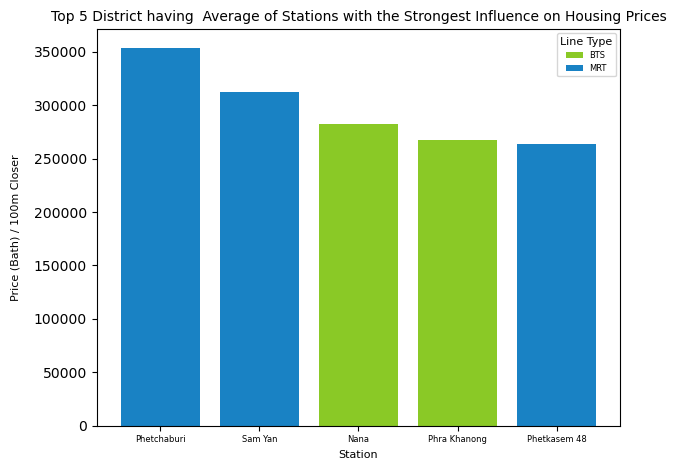

In [494]:
# Modify the coefficient values to be positive for plotting
top5_station_plot = station_coef_sample.copy()

# Define colors for each line type and create a color mapping for the plot
top5_station_plot['color'] = top5_station_plot['line'].apply(lambda x: '#8ac926' if x == 'BTS' else '#1982c4')

# Create the bar plot with colors based on line types
bars = plt.bar(x=top5_station_plot['station_name'], height=top5_station_plot['Coefficient'], color=top5_station_plot['color'])

# Labeling and formatting
plt.xlabel("Station", fontsize=8)
plt.ylabel("Price (Bath) / 100m Closer", fontsize=8, rotation=90, labelpad=10)
plt.title("Top 5 District having  Average of Stations with the Strongest Influence on Housing Prices", fontsize=10)
plt.xticks(rotation=0, fontsize=6)

# Create a custom legend for line colors
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#8ac926', label='BTS'), 
                   Patch(facecolor='#1982c4', label='MRT')]
plt.legend(handles=legend_elements, title="Line Type", fontsize=6, title_fontsize='8')

# Save and show the plot
plt.tight_layout()
plt.savefig('../Figures/top_5_stations.png', dpi=200)
plt.show()


In [496]:
dis_sample = get_district.groupby(['district','station_name']).size().reset_index(name='count')

station_coef_sample = pd.merge(station_coef,dis_sample, left_on= 'Feature', right_on= 'station_name')
district_station_coef = station_coef_sample.groupby('district')['Coefficient'].agg(['mean', 'count']).sort_values(by='mean',ascending = False).reset_index()
district_station_coef['count'].skew(), district_station_coef['count'].mean(),district_station_coef['count'].median()

(0.7668694396070224, 4.282051282051282, 4.0)

In [497]:
top5_district_station_coef = district_station_coef.sort_values(by = 'mean',ascending = False)
top5_district_station_coef = district_station_coef[district_station_coef['count'] >=4].head(5)
top5_district_station_coef

,district,mean,count
2,Pathum Wan,186002.906679,7
6,Mueang Nonthaburi,125622.894633,10
8,Chatuchak,110760.121317,12
9,Phasi Charoen,108130.473007,5
10,Ratchathewi,107439.674220,7


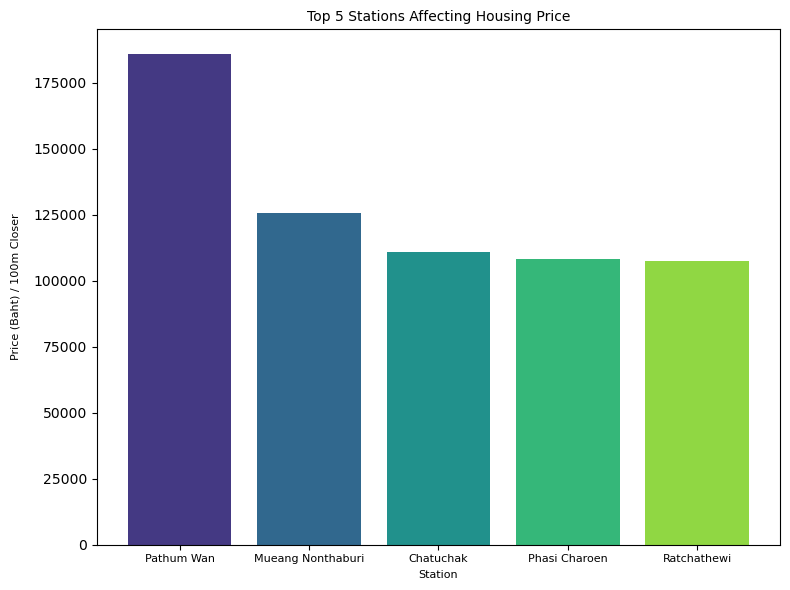

In [498]:
# Modify the coefficient values to be positive for plotting
top5_station_plot = top5_district_station_coef.copy()
top5_station_plot['mean'] = top5_station_plot['mean'].abs()  # Ensuring positive values for plotting

# Define the Viridis color palette
color_palette = sns.color_palette("viridis", len(top5_station_plot))

# Create the bar plot with colors based on the Viridis palette
plt.figure(figsize=(8, 6))
bars = plt.bar(
    x=top5_station_plot['district'], 
    height=top5_station_plot['mean'], 
    color=color_palette
)

# Labeling and formatting
plt.xlabel("Station", fontsize=8)
plt.ylabel("Price (Baht) / 100m Closer", fontsize=8, rotation=90, labelpad=10)
plt.title("Top 5 Stations Affecting Housing Price", fontsize=10)
plt.xticks(rotation=0, fontsize=8)

# Save and show the plot
plt.tight_layout()
plt.savefig('../Figures/top_5_stations.png', dpi=200)
plt.show()

---

### 2. Stations near Ha Yaek Lat Phrao station

In [535]:
latprao = station_coef_sample.copy()
latprao['line'] = latprao['station_name'].apply(lambda x: x.split(' ')[-1] if isinstance(x, str) else x)
latprao['station_name'] = latprao['station_name'].apply(lambda x:  ' '.join(x.split(' ')[:-1]) if isinstance(x, str) else x)
latprao = latprao[latprao['station_name'].isin(['Phahon Yothin', 'Sena Nikhom', 'Mo Chit', 'Ratchayothin', 'Lat Phrao', 
                                                 'Ratchadaphisek','Chatuchak Park', 'Kamphaeng Phet', 'Sutthisan', 'Saphan Kwai','Ha Yaek Lat Phrao'])]
latprao = latprao.groupby(['line','station_name'])['Coefficient'].mean().reset_index(name = 'Coefficient')
latprao = latprao.sort_values(by = 'Coefficient', ascending = False)
latprao

,line,station_name,Coefficient
1,BTS,Mo Chit,305732.411350
3,BTS,Saphan Kwai,260838.865520
4,BTS,Sena Nikhom,223722.658562
0,BTS,Ha Yaek Lat Phrao,183238.607781
8,MRT,Phahon Yothin,172544.051679
9,MRT,Ratchadaphisek,117635.790254
10,MRT,Sutthisan,81205.604101
7,MRT,Lat Phrao,64026.063271
2,BTS,Ratchayothin,57358.334621
5,MRT,Chatuchak Park,57024.464070


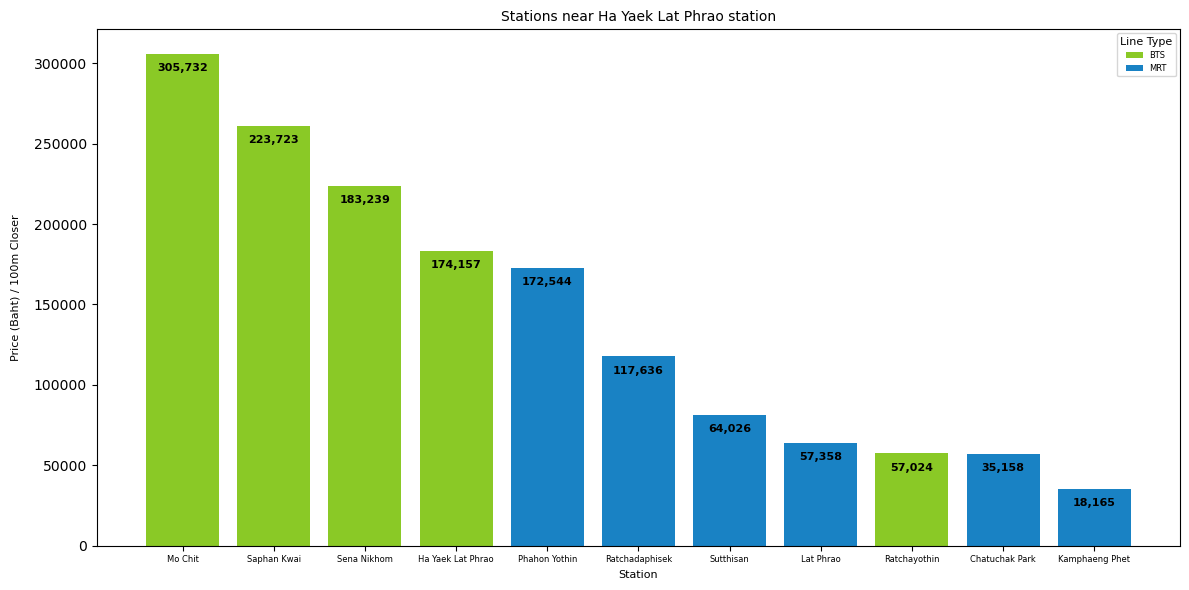

In [537]:
# Define colors for each line type and create a color mapping for the plot
latprao['color'] = latprao['line'].apply(lambda x: '#8ac926' if x == 'BTS' else '#1982c4')

plt.figure(figsize=(12,6))

# Create the bar plot with colors based on line types
bars = plt.bar(x=latprao['station_name'], height=latprao['Coefficient'], color=latprao['color'])

# Add data labels above each bar, formatted as integer with commas
for bar, coeff in zip(bars, Chatuchak['Coefficient']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,   
        bar.get_height() - 12000,             
        f'{coeff:,.0f}',                     
        ha='center',                         
        va='bottom',                         
        fontsize=8,                          
        color='black',
        weight='bold'
    )

# Labeling and formatting
plt.xlabel("Station", fontsize=8)
plt.ylabel("Price (Baht) / 100m Closer", fontsize=8, rotation=90, labelpad=10)
plt.title("Stations near Ha Yaek Lat Phrao station", fontsize=10)
plt.xticks(rotation=0, fontsize=6)

# Create a custom legend for line colors
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#8ac926', label='BTS'), 
                   Patch(facecolor='#1982c4', label='MRT')]
plt.legend(handles=legend_elements, title="Line Type", fontsize=6, title_fontsize='8')

# Save and show the plot
plt.tight_layout()
plt.savefig('../Figures/stations_in_Chatuchak.png', dpi=300)
plt.show()
